<a href="https://colab.research.google.com/github/thhtruc/NeuralNetwork/blob/main/NN_pytorch_FMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
### Neural Network=

%matplotlib inline 
%config InlineBackend.figure_format = 'retina'


import torch
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import time
from torch import nn
from torch import optim
import torch.nn.functional as F

#define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])


In [3]:
# Download and load the training data
trainset = datasets.FashionMNIST('F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)


Extracting F_MNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to F_MNIST_data/FashionMNIST/raw




Extracting F_MNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to F_MNIST_data/FashionMNIST/raw




Extracting F_MNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to F_MNIST_data/FashionMNIST/raw




Extracting F_MNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to F_MNIST_data/FashionMNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


In [5]:
class Network(nn.Module):
    def __init__(self, input_size, output_size, hidden_layers, drop_p=0.5):
        super().__init__()
        # Add the first layer, input to a hidden layer
        self.hidden_layers = nn.ModuleList([nn.Linear(input_size, hidden_layers[0])])
        
        # Add a variable number of more hidden layers
        layer_sizes = zip(hidden_layers[:-1], hidden_layers[1:])
        # print(layer_sizes)
        self.hidden_layers.extend([nn.Linear(h1, h2) for h1, h2 in layer_sizes])
        
        self.output = nn.Linear(hidden_layers[-1], output_size)
        
        self.dropout = nn.Dropout(p=drop_p)
        
    def forward(self, x):
        # Forward through each layer in `hidden_layers`, with ReLU activation and dropout
        for linear in self.hidden_layers:
            x = F.relu(linear(x))
            x = self.dropout(x)  
        x = self.output(x)
        
        return F.log_softmax(x, dim=1)

In [58]:
# Create the network, define the criterion and optimizer
model = Network(784, 10, [516, 256], drop_p=0.5)
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [59]:
# Implement a function for the validation pass
def validation(model, testloader, criterion):
    test_loss = 0
    accuracy = 0
    for images, labels in testloader:

        images.resize_(images.shape[0], 784)

        output = model.forward(images)
        loss = criterion(output, labels)
        test_loss += loss.item()

        ps = torch.exp(output)
        equality = (labels.data == ps.max(dim=1)[1])
        accuracy += torch.mean(equality.type(torch.FloatTensor))
    
    return test_loss, accuracy

In [60]:
epochs = 10
steps = 0
running_loss = 0
train_losses, test_losses = [], []
for e in range(epochs):
    model.train()
    for images, labels in trainloader:
        steps += 1
        
        # Flatten images into a 784 long vector
        images.resize_(images.size()[0], 784)
        
        optimizer.zero_grad()
        output = model.forward(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    else:
        test_loss = 0
        accuracy = 0
        # Make sure network is in eval mode for inference
        model.eval()
        with torch.no_grad(): 
            test_loss, accuracy = validation(model, testloader, criterion)
            
            # Make sure training is back on
        model.train()
        
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))
        print("Epoch: {}/{}.. ".format(e+1, epochs),
                  "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
                  "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
                  "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))
        running_loss = 0

Epoch: 1/10..  Training Loss: 0.614..  Test Loss: 0.479..  Test Accuracy: 0.820
Epoch: 2/10..  Training Loss: 0.487..  Test Loss: 0.422..  Test Accuracy: 0.848
Epoch: 3/10..  Training Loss: 0.455..  Test Loss: 0.402..  Test Accuracy: 0.854
Epoch: 4/10..  Training Loss: 0.437..  Test Loss: 0.392..  Test Accuracy: 0.857
Epoch: 5/10..  Training Loss: 0.428..  Test Loss: 0.390..  Test Accuracy: 0.860
Epoch: 6/10..  Training Loss: 0.411..  Test Loss: 0.378..  Test Accuracy: 0.860
Epoch: 7/10..  Training Loss: 0.402..  Test Loss: 0.376..  Test Accuracy: 0.865
Epoch: 8/10..  Training Loss: 0.393..  Test Loss: 0.375..  Test Accuracy: 0.866
Epoch: 9/10..  Training Loss: 0.388..  Test Loss: 0.363..  Test Accuracy: 0.869
Epoch: 10/10..  Training Loss: 0.382..  Test Loss: 0.367..  Test Accuracy: 0.865


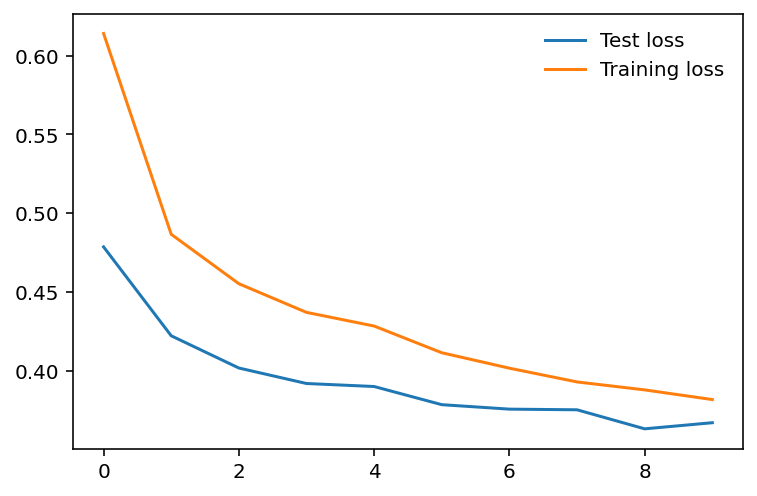

In [61]:
plt.plot(test_losses, label='Test loss')
plt.plot(train_losses, label="Training loss")
plt.legend(frameon=False)

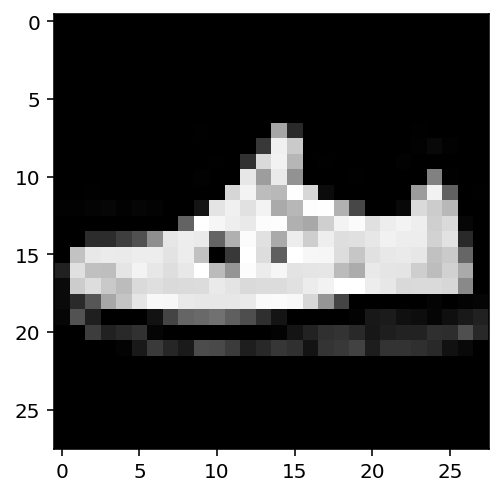

tensor([[1.9637e-06, 3.6447e-09, 1.2279e-06, 9.8887e-08, 8.9454e-08, 9.1991e-01,
         8.7726e-07, 8.0037e-02, 1.7436e-05, 3.0255e-05]],
       grad_fn=<ExpBackward>)
5
predict sandal


In [26]:
%matplotlib inline


images, labels = next(iter(testloader))
img = images[0].view(1, 784)
labelNames = ["top", "trouser", "pullover", "dress", "coat",
	"sandal", "shirt", "sneaker", "bag", "ankle boot"]

output = model(img)
ps = torch.exp(output)
plt.imshow(images[0].numpy().squeeze(), cmap='Greys_r')
plt.show()
print(ps)
index_label = torch.argmax(ps)
index_label = index_label.numpy()
print(index_label)
print('predict', labelNames[index_label])

In [32]:
accuracy = 0 
equality = (labels.data == ps.max(dim=1)[1])
print(equality.type(torch.FloatTensor))
accuracy += equality.type(torch.FloatTensor).mean()
print(ps.max(dim=1)[1])
print(equality)
print(accuracy)

tensor([1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([5])
tensor([ True, False,  True, False, False, False,  True, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False,  True, False, False,  True, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False])
tensor(0.0781)
